In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(reticulate)
    library(gridExtra)
    library(grid)
    library(ggpubr)
    library(scales)
}))
use_condaenv("R42")
#use_python("/home/vsevim/software/anaconda3/envs/R42/bin/python")
source_python("/home/vsevim/prj/workflows/ckd/secondary/mixture.py")
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    # data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"

    # prj_name = "Screen2_101vecs"
    # # data_subdir_suffixes = "L1,L2,L3,L4"     
    # secondary_a_path = "/home/vsevim/prj/1012-ckd/S2/analysis/secondary/"
    # save_seurat_h5 = "NO"

}


In [4]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [5]:
integrated_h5_path  <- paste0(secondary_a_path, "integrated/seurat_objects/integrated_wo_guide_calls.h5seurat")
updated_integrated_h5_path  <- paste0(secondary_a_path, "integrated/seurat_objects/integrated.h5seurat")
seurat_combined <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


In [6]:
ncol(seurat_combined)

[1] 27141

Use only singlets (actually I didn't include the singlets in the integrated file, so this step is unnecessary)

In [7]:
seurat_combined <- subset(seurat_combined, subset = status == 'singlet')

# Call all guides

Skipping guides with less than 50 counts
Running Lib_1 
Completed Lib_1 


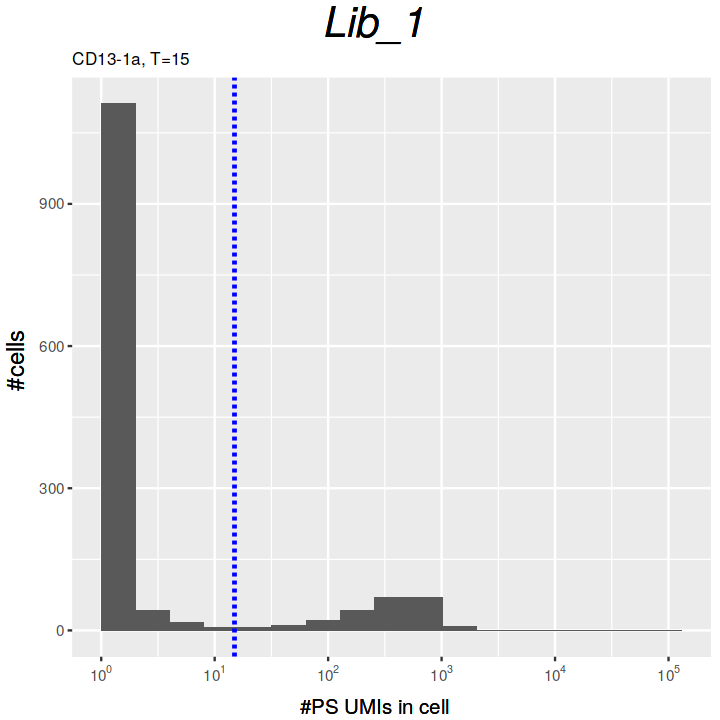

In [39]:
libraries = unique(seurat_combined$library)
min_guide_count = 50
df_thresholds = data.frame(batch=character(0), guide=character(0), threshold=numeric(0))

cat(blue("Skipping guides with less than", min_guide_count, "counts\n"))
for(l in seq_along(libraries)){
    # subset 
    library_name = libraries[[l]]
    cat(blue("Running", library_name, "\n"))
    seurat  <- subset(seurat_combined, subset = library == library_name)

    DefaultAssay(seurat) <- "sgRNA"
    df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
    rownames(df_guide_counts) <- NULL

    CUTOFF_PROB = 0.5
    guides = colnames(df_guide_counts)
    plots = list()

    for(i in seq_along(guides)) {
        guide = guides[[i]]
        y = df_guide_counts[,guide]
        select_nonzeros = y > 0
        y = y[select_nonzeros]
        index = nrow(df_thresholds) + 1
        if(length(y) <= min_guide_count) {
            cat("Skipping", guide, length(y), "guides found\n")
            df_thresholds[index,] <-  c(library_name, guide, NA)
            next
        }
        
        calls <- pgmix(y)
        df_calls = as.data.frame(calls)
        df_calls['counts'] = y
        colnames(df_calls) = c('call', 'prob', 'count')
        options(repr.plot.width=4, repr.plot.height=4)
        head(df_calls)
        dim(df_calls)
        select_gaussian_assigned = df_calls[, 'prob'] > CUTOFF_PROB

        df_gauss = df_calls[select_gaussian_assigned,]
        dim(df_gauss)
        
        # head(df_gauss)
        threshold = min(df_gauss$count)
        #cat("threshold=", threshold)
        filter_y = y > 0
        y_filtered = y[filter_y]
        df_y = as.data.frame(y_filtered)
        head(df_y)
        
        options(repr.plot.width=3.3, repr.plot.height=2.4)
        bin_breaks <- c(1,2,2*2^(1:16))
        title = paste0(guide, ", T=", threshold)

        ggp1 <- ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
        geom_histogram(breaks=bin_breaks) + 
        scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
            labs(title=title, x=NULL, y=NULL) +  
            geom_vline(xintercept=threshold, color="blue", linetype="dashed", size=1) +
            theme(plot.title = element_text(size=10))

        plots <- append(plots, list(ggp1))
        #index = nrow(df_thresholds) + 1
        df_thresholds[index,] <-  c(library_name, guide, threshold)
        break        
    }
    cat(green("Completed", library_name, "\n"))
    flush.console()
    options(repr.plot.width=6, repr.plot.height=6)
    plt <- gridExtra::grid.arrange(
        grobs = plots, 
        ncol = 1, 
        bottom=textGrob("#PS UMIs in cell", gp=gpar(fontsize=12)),
        left=textGrob("#cells", gp=gpar(fontsize=14), rot=90),
        top = textGrob(library_name, gp=gpar(fontsize=25, font=3))
    )
    grid::grid.draw(plt)
    pdf_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/guide_distr/"
    break
}

#### Debug

[1] FALSE

In [29]:
sum(df_guide_counts[,guide] >= 1)

[1] 1407

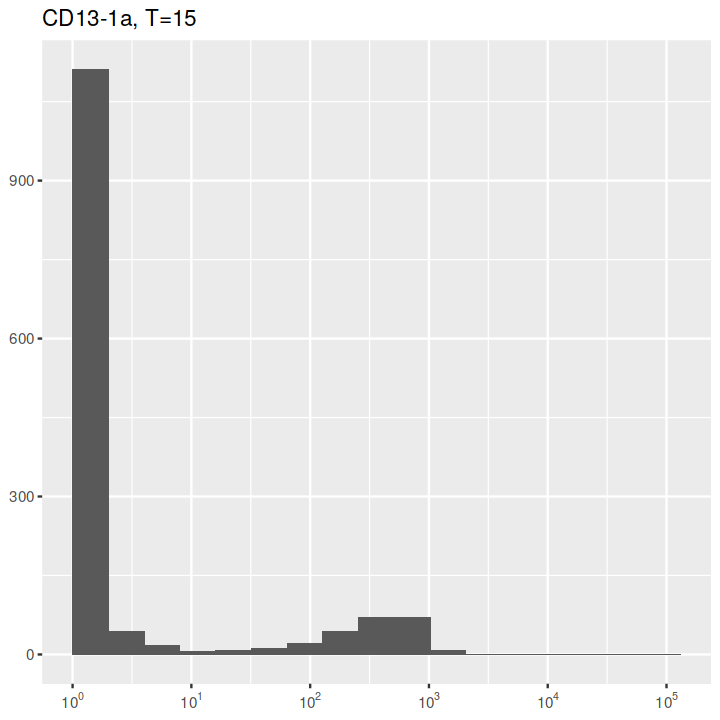

In [23]:
ggplot(df_y, aes(x = y_filtered)) +    # Draw each column as histogram
    geom_histogram(breaks=bin_breaks) + 
    scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
        labs(title=title, x=NULL, y=NULL)  


In [34]:
ggplot_build(ggp1)$data[[1]]

y,count,x,xmin,xmax,density,ncount,ndensity,flipped_aes,PANEL,group,ymin,ymax,colour,fill,linewidth,linetype,alpha
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<fct>,<int>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<lgl>
1111,1111,0.15,0.0,0.3,2.623,1.0000,1.0000,FALSE,1,-1,0,1111,NA,grey35,0.5,1,NA
43,43,0.45,0.3,0.6,0.102,0.0387,0.0387,FALSE,1,-1,0,43,NA,grey35,0.5,1,NA
17,17,0.75,0.6,0.9,0.040,0.0153,0.0153,FALSE,1,-1,0,17,NA,grey35,0.5,1,NA
6,6,1.05,0.9,1.2,0.014,0.0054,0.0054,FALSE,1,-1,0,6,NA,grey35,0.5,1,NA
7,7,1.35,1.2,1.5,0.017,0.0063,0.0063,FALSE,1,-1,0,7,NA,grey35,0.5,1,NA
11,11,1.66,1.5,1.8,0.026,0.0099,0.0099,FALSE,1,-1,0,11,NA,grey35,0.5,1,NA
21,21,1.96,1.8,2.1,0.050,0.0189,0.0189,FALSE,1,-1,0,21,NA,grey35,0.5,1,NA
43,43,2.26,2.1,2.4,0.102,0.0387,0.0387,FALSE,1,-1,0,43,NA,grey35,0.5,1,NA
70,70,2.56,2.4,2.7,0.165,0.0630,0.0630,FALSE,1,-1,0,70,NA,grey35,0.5,1,NA


In [33]:
plots

list()

In [38]:
sum(df_guide_counts[,guide] > 512 & df_guide_counts[,guide] < 1024)

[1] 70